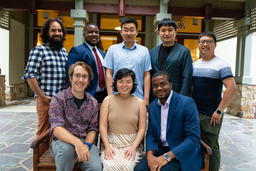

In [25]:
from PIL import Image
import requests
from io import BytesIO

size = (256, 256)
url = "https://cs.vt.edu/content/website_cs_vt_edu/en/faculty-search/jcr:content/article-image.transform/xl-medium/image.jpg"
response = requests.get(url)
content = BytesIO(response.content)
img = Image.open(content)
img.thumbnail(size, Image.LANCZOS)
img.show()

# Diffusion Process and Reverse Process

## Specific Prerequisites
* Markov Chain in Probability Graph Module
* Variational Autoencoder
* U-Net

## Noise Process

$q(x_t|x_{t-1}) = N(x_t;\sqrt{1-\beta_t}x_{t-1},\beta_tI)$

$q(x_{1:t} | x_0) = \prod p(x_t|x_{t-1})$
### Reparametriation
$$
    \alpha_t = 1 - \beta_t \\
    \bar \alpha_t = \prod_{i=1}^t \alpha_i \\
    \epsilon \sim N(0, I)\\
    x_t = \sqrt{1-\beta_t}x_{t-1}+\sqrt{\beta_t}\epsilon\\
    = \sqrt{\alpha_t}x_{t-1} + \sqrt{1-\alpha_t}\epsilon\\
    = \sqrt{\alpha_t\alpha_{t-1}}x_{t-2} + \sqrt{1-\alpha_t\alpha_{t-1}}\epsilon\\
    = ... \\
    =\sqrt{\bar\alpha_t}x_0 + \sqrt{1-\bar \alpha_t}\epsilon \\
    q(x_t | x_0) = N(\sqrt{\bar \alpha_t}x_0, \sqrt{1-\bar \alpha_t}I) \\
$$

## Autoencoder
Autoencoder is a neural network to learn the characteristic of the data. It has some features as follows:
1. input and target are the same via downsampling and upsampling
  * kind of unsupervised-learning
2. has power to reduce the dimension in the encoder part


## Denoising Process
$p_\theta(x_{t-1}|x_t)$ is reverse process of the noise process. In here, the model does not know $q(x_{t-1}|x_t)$ (not $q(x_t|x_{t-1})$). It's hard to calculate $q(x_{t-1}|x_t)$.
Hence, we guess the reverse distribution is almost like Gaussion distribution.
$$
  p_\theta(x_{t-1}|x_t) = N(x_{t-1};\mu_\theta(x_t,t), {\sum}_\theta(x_t,t))\\
  s.t.\ p_\theta(x_{0:T}) = p(x_T)\prod^T_t p_\theta(x_{t-1}|x_t)
$$
Therefore, we use deep learning to lean the $\mu$ and $\sum$ for the reverse distribution. The loss function is from cross-entropy of Markov chain of condition probability and it's similar to $L_{VAE}$.
$$
  L = \sum_t^T L_{t}\\
  L_t =  D_{KL}(q(x_t|x_{t+1}, x_0) \| p_\theta(x_{t}|x_{t+1}))\\
  L_0 = -ln\ p_\theta(x_0|x_1)\\
  L_T = D_{KL}(q(x_T, x_0) \| p_\theta(x_{T}))
$$
    
The mean and variance are $\tilde \mu(x_t, x_0) = \frac{\sqrt{1-\beta_{t-1}}x_{t}}{1-\bar \alpha_t}x_0+ \frac{\sqrt{\alpha_t}(1-\bar \alpha_{t-1})}{1-\bar \alpha_t}x_t$ and Var is $\tilde\beta_t I = \frac{(1-\bar \alpha_{t-1})}{1-\bar \alpha_t}\beta_t I$. And the $L_{t-1}$ approximates to $E_{x,\epsilon}[\frac{1}{2\|{\sum}_\theta\|_2^2}\|\frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1-\bar \alpha_{t}}}\epsilon) - \mu_\theta(x_t, t)\|_2^2]$.
However, it's still complicated. What's if we predict $\epsilon$ ?
$$
\mu(x_t, t) = \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1-\bar \alpha_{t}}}\epsilon_\theta(x_t, t)) = x_{t-1}\\
  L_{t-1} = E_{x_t, \epsilon}[\frac{\beta_t^2}{2\alpha_t(1-\bar \alpha_t)\|{\sum}_\theta\|_2^2}\|\epsilon - \epsilon_\theta(\sqrt{\bar \alpha_t}x_0 + \sqrt{1 - \bar \alpha_t}\epsilon, t)\|_2^2]
$$

### Algorithms
* Training
  0. loop
  1. $x_0 \sim q(x_0)$
  2. $t \sim U(0,T)$
  3. $\epsilon \sim N(0,I)$
  4. $\theta = \theta + \nabla_\theta MSE(\epsilon, \epsilon_\theta(\sqrt{\bar \alpha_t}x_0 + \sqrt{1 - \bar \alpha_t}\epsilon, t))$
* Sampling
  1. $x_T \sim N(0, I)$
  2. for loop in steps $t\ in\ [T:0]$
  3. $\ \ x_{t-1}=\frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1-\bar \alpha_{t}}}\epsilon_\theta(x_t, t)) + \sigma_t Z$
  4. return $x_0$    

**$\epsilon_\theta$ is `U-Net` neual network model.**

### Embedding
Use `sinusoidal positione mbedding` to define the postion of the noise in the sequence.

In [5]:
from enum import Enum, auto
class Beta():
  class schedule(Enum):
    linear = auto()
    cosin = auto()

  def __init__(self, start, end, times):
    """
    diffusion rate scheduler
    """
    self.start = start
    self.end = end
    self.times = times
    if not all([0.0 <= self.start < 1.0, 0.0 <= self.end < 1.0, self.start < self.end]):
      raise ValueError("Beta should between 0.0 and 1.0")

  def get_schedule(self, typeof: schedule):
    if typeof == Beta.schedule.linear:
      return np.linspace(self.start, self.end, self.times)
    elif typeof == Beta.schedule.cosin:
      """
      Alex Nichol, Prafulla Dhariwal (2021), Improved Denoising Diffusion Probabilistic Models
      \beta = 1 - \frac{\bar \alpha_t}{\bar \alpha_{t-1}}
      """
      import math
      def bar_alpha(t, s = 0.008):
        """
        f = cos(\frac{t/T+s}{1+s} \frac{\pi}{2})^2,\ where\ s=0.008
        """
        return (math.cos((t + s) / (1+s) * math.pi / 2) ** 2)
      clip_beta = 0.999
      return np.array([min(1 - bar_alpha((i) / self.times) / bar_alpha( (i-1) / self.times), clip_beta) for i in range(1, self.times+1)])
    return None

In [6]:
from IPython.utils.frame import extract_vars_above
import numpy as np
import torch


class GaussianDiffusion():
  """
  q is forward process
  p is backward process
  """

  def __init__(self,
               beta: Beta,
               times = None,
               schedulerType = Beta.schedule.linear):
    """
    q(x_t|x_{t-1}) = N(x_t;\sqrt{1-\beta_t}x_{t-1},\beta_tI)
    q(x_{1:t} | x_0) = \prod p(x_t|x_{t-1})

    Reparametriation: for the close-form representation
    \alpha_t = 1 - \beta_t
    \bar \alpha_t = \prod_{i=1}^t \alpha_i
    q(x_t|x_{t-1}) = \sqrt{\bar \alpha_t}x_0 + \sqrt{1-\bar \alpha_t}\epsilon
    q(x_t | x_0) = N(\sqrt{\bar \alpha_t}x_0, \sqrt{1-\bar \alpha_t}I)
    """
    self.B = beta
    self.betas = self.B.get_schedule(schedulerType)
    if self.betas is None:
      raise Exception("please check the schedule type")
    self.times = times
    self.alphas = 1 - self.betas
    self.alphas_hat = np.cumprod(self.alphas, axis=0)

    self.alphas_prodprev = np.append(1.0, self.alphas_hat[:-1])

    # For \sqrt{\bar \alpha_t}x_0 + \sqrt{1-\bar \alpha_t}\epsilon
    # and N(\sqrt{\bar \alpha_t}x_0, \sqrt{1-\bar \alpha_t}I)
    # that shared the \sqrt{\bar \alpha_t} and \sqrt{1-\bar \alpha_t}
    self.firstpart_q_alphas_hat = np.sqrt(self.alphas_hat)
    self.secondpart_q_alphas_hat = np.sqrt(1.0 - self.alphas_hat)

  def noise(self, x_0, istorch=False):
    """
    standard distribution sampling
    """
    if istorch:
      return torch.randn_like(x_0)
    else:
      return np.random.randn(*x_0.shape)

  def q_sample(self, x_0, t, noise=None):
      """
      Forward: noising
      return x_t
      """
      if noise is None:
          noise = self.noise(x_0) # epsilon
      return self.firstpart_q_alphas_hat[t-1] * x_0 \
          + self.secondpart_q_alphas_hat[t-1] \
          * noise

  def p_sample(self, predictor: torch.nn.Module, x_t, t):
    """
    x_{t-1}=\frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1-\bar \alpha_{t}}}\epsilon_\theta(x_t, t)) + \sigma_t Z
    """
    if self.betas is None:
      raise Exception("please create instance with bets")
    betas_t = self.betas[t-1]

    # \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1-\bar \alpha_{t}}}\epsilon_\theta(x_t, t))
    x_t_1 = torch.sqrt(1.0 / self.alphas[t-1]) * ( x_t - (betas_t / self.secondpart_q_alphas_hat[t-1]) * predictor(x_t, t))

    # \sigma_t Z
    alphas_hat_1 = nn.functional.pad(self.alphas_hat[:-1], (1, 0), value=1.0)
    extra = torch.sqrt(self.betas * alphas_hat_1 / (1.0 - self.alphas_hat)) * torch.randn_like(x_t) if t > 0 else 0

    return x_t_1 + extra


  def loss_function(self, x_0, epsilon_theta: torch.nn.Module, steps = 100, t = None, epsilon = None):
    """
    E_{x,\epsilon}[const*\frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1-\bar \alpha_{t}}}\epsilon) - \mu_\theta(x_t, t)\|_2^2]
    const = \frac{1}{2\|{\sum}_\theta\|_2^2}\|
    => \hat E_{x,\epsilon}[\frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1-\bar \alpha_{t}}}\epsilon) - \mu_\theta(x_t, t)\|_2^2]
    """
    t = torch.randint(0, steps, (x_0.shape[0],), dtype=torch.long) if t is None else t
    epsilon = torch.randn_like(x_0) if epsilon is None else epsilon
    xt = self.q_sample(x_0, t, noise=epsilon)
    eps_theta = epsilon_theta(xt, t)
    return torch.nn.MSELoss(epsilon, eps_theta) # it would gradient MSE for SGD

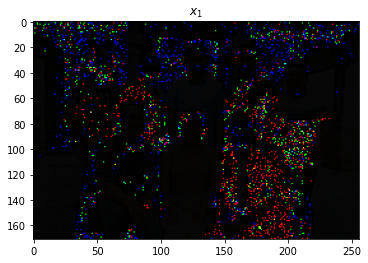

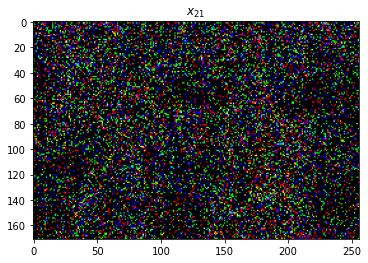

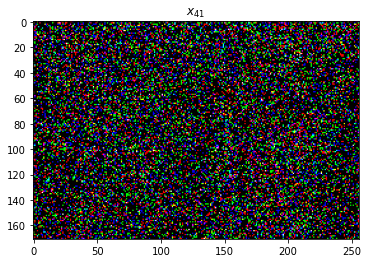

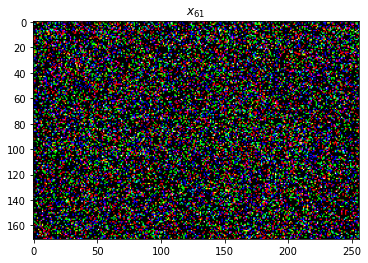

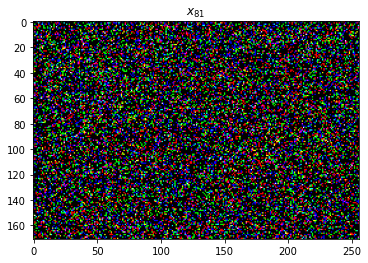

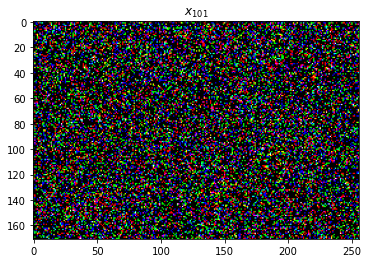

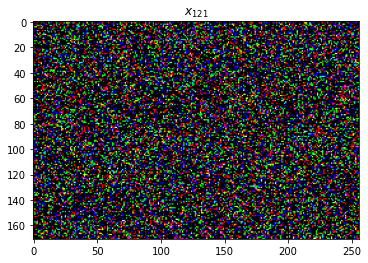

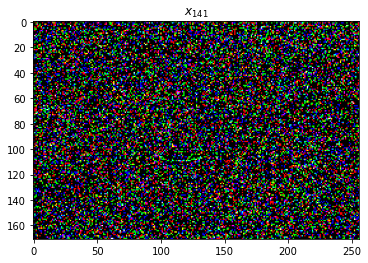

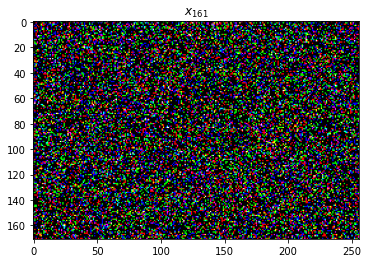

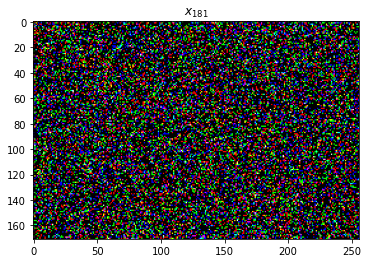

In [6]:
from matplotlib import pyplot as plt
"""
Jonathan Ho, Ajay Jain, Pieter Abbeel (2020), Denoising Diffusion Probabilistic Models
recommends the beta should from 0.0001 to 0.02
"""
scheduler_end = 0.02
for t in range(1, 201, 20):
  model = GaussianDiffusion(Beta(0.0001, scheduler_end, t), schedulerType= Beta.schedule.cosin)
  data = model.q_sample(np.array(img), t)
  plt.imshow(data.astype('uint8'))
  plt.title("$x_{"f"{t}""}$")
  plt.show()

In [95]:
from torch import nn
import math
class UNet(nn.Module):
  """
  please please please read Olaf Ronneberger, Philipp Fischer, Thomas Brox (2015),
  U-Net: Convolutional Networks for Biomedical Image Segmentation
  The structure is downsampling and upsampling, and connecting to each blocks.
  """

  class TimeEmbedded(nn.Module):
    def __init__(self, dim):
      super().__init__()
      self.dim = dim
  
    def forward(self, x):
      """
      Vaswani et al. (2017)
      PE_(pos,2i) = sin(pos/10000^(2i/d_model))
      PE_(pos,2i+1) = cos(pos/10000^(2i/d_model))

      According to https://huggingface.co/blog/annotated-diffusion, 
      https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL#scrollTo=buW6BaNga-XH,
      and https://pytorch.org/tutorials/beginner/transformer_tutorial.html
      I don't know why we need to logarithmize the number. 
      """
      temp_term = -math.log(10000) / (self.dim//2 - 1) # log (10000^(2 / dim)) = (log(10000)*2) / dim
      div_term = torch.exp(torch.arange(start=0, end = self.dim, step=2) * temp_term)
      embedded = x[:, None] * div_term[None,:]
      return torch.cat((embedded.sin(), embedded.cos()), dim = -1)

  class Conv3x3ReLU(nn.Module):
    def __init__(self, insize, out, time_dim, padding = 1, dim = 2, stride=1, bias = True):
      super().__init__()

      class_nd = getattr(nn, f"Conv{dim}d") # exception if not found
      self.conv0 = class_nd( in_channels = insize, out_channels = out,
                            kernel_size = 3, padding = padding, bias = bias,
                            stride = stride)
      self.relu0 = nn.ReLU(inplace=True)
      self.conv1 = class_nd( in_channels = out, out_channels = out,
                            kernel_size = 3, padding = padding, bias = bias,
                            stride = stride)
      self.relu1 = nn.ReLU(inplace=True)

      # refer to openai/guided-diffusion
      self.emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_dim,out,),
            )

    def forward(self, x, time_embedded = None):
      for i in range(2):
        if i == 1 and time_embedded is not None:
          e = self.emb_layers(time_embedded)
          while len(e.shape) < len(x.shape):
            e = e[..., None]
        x = getattr(self, f"relu{i}")(getattr(self, f"conv{i}")(x))
      return x

  class Conv3x3GeLU(Conv3x3ReLU):
    def __init__(self, insize, out, time_dim, padding = 1, dim = 2, stride=1, bias = True):
      super().__init__(insize, out, time_dim, padding, dim, stride, bias)
      self.relu0 = torch.nn.GELU()
      self.relu1 = torch.nn.GELU()

  class MaxPooling2x2(nn.Module):
    def __init__(self, dim = 2):
      super().__init__()
      maxpool_nd = getattr(nn, f"MaxPool{dim}d")
      self.pooling = maxpool_nd(kernel_size = 2, stride=2) # stride would as same as kernel which would sample to half of the data

    def forward(self, x):
      return self.pooling(x)

  class UpPooling(nn.Module):
    def __init__(self, insize, out, time_dim,
                 dim = 2,
                 mode = None,
                 kernelsize=3,
                 kernelsize_up = 2,
                 stride = 2,
                 padding = 0,
                 bias=False):
      super().__init__()
      class_nd = getattr(nn, f"Conv{dim}d")
      mid = int(2**((np.log2(insize)  + np.log2(out)) // 2))
      if mode:
        self.sample = nn.Sequential(
            nn.Upsample(mode=mode, scale_factor=2),
            class_nd( mid, out, kernel_size=1, groups=1, stride=stride)
            )
      else:
        uplearnableclass = getattr(nn, f"ConvTranspose{dim}d")
        self.sample = uplearnableclass(in_channels=mid, out_channels=out, kernel_size=kernelsize_up,
                                       stride=stride+1, padding=padding-1)
      self.conv = class_nd( in_channels=insize, out_channels=mid,
                            kernel_size=kernelsize, bias=bias, stride=stride, padding=padding)
      
            # refer to openai/guided-diffusion
      self.emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_dim, out,),
            )

    def forward(self, x, time_embedded = None):
      if time_embedded is not None:
        e = self.emb_layers(time_embedded)
        while len(e.shape) < len(x.shape):
            e = e[..., None]
      y = self.conv(x)
      return self.sample(y)

  def __init__(self, input_size, out_size, features, time_dim, bias = True):
    super().__init__()

    self.time_embedding = nn.Sequential(
        self.TimeEmbedded(time_dim),
        nn.Linear(time_dim, time_dim),
        nn.SiLU(),
        nn.Linear(time_dim, time_dim)
    )

    exp = 0
    self.inlayer1 = self.Conv3x3GeLU(input_size, features*(2**exp), time_dim); exp += 1
    self.expend1 = nn.Conv2d( in_channels = features*(2**(exp-1)), out_channels = features*(2**(exp)),
                            kernel_size = 3, bias = bias, stride = 1, padding=1)
    self.inlayer2 = self.Conv3x3GeLU(features*(2**(exp-1)), features*(2**exp), time_dim); exp += 1
    self.expend2 = nn.Conv2d( in_channels = features*(2**(exp-1)), out_channels = features*(2**(exp)),
                            kernel_size = 3, bias = bias, stride = 1, padding=1)
    self.inlayer3 = self.Conv3x3GeLU(features*(2**(exp-1)), features*(2**exp), time_dim); exp += 1
    self.expend3 = nn.Conv2d( in_channels = features*(2**(exp-1)), out_channels = features*(2**(exp)),
                            kernel_size = 3, bias = bias, stride = 1, padding=1)
    self.inlayer4 = self.Conv3x3GeLU(features*(2**(exp-1)), features*(2**exp), time_dim); exp += 1
    self.expend4 = nn.Conv2d( in_channels = features*(2**(exp-1)), out_channels = features*(2**(exp)),
                            kernel_size = 3, bias = bias, stride = 1, padding=1)

    self.maxpool1 = self.MaxPooling2x2()
    self.maxpool2 = self.MaxPooling2x2()
    self.maxpool3 = self.MaxPooling2x2()
    self.maxpool4 = self.MaxPooling2x2()

    self.bottom = self.Conv3x3ReLU(features*(2**(exp-1)), features*(2**exp), time_dim)
    self.up = nn.Upsample(mode="bilinear", scale_factor=2)


    self.outlayer = nn.ModuleList([self.UpPooling(features*(2**i)*2, features*(2**(i-1)), \
                                                  time_dim, kernelsize = 3, bias = bias, \
                                                  stride = 1, padding=1) \
                                  for i in range(exp, 0, -1)]); exp = 0

    self.conv1x1 = nn.Conv2d( in_channels = features*(2**exp), out_channels = out_size,
                            kernel_size = 2, bias = bias, stride = 2, padding=0)
    
  def forward(self, x, timestamp):

    time_position_embedded = self.time_embedding(timestamp)

    in1 = self.inlayer1(x, time_position_embedded)
    in2 = self.inlayer2(self.maxpool1(in1), time_position_embedded)
    in3 = self.inlayer3(self.maxpool2(in2), time_position_embedded)
    in4 = self.inlayer4(self.maxpool3(in3), time_position_embedded)

    out = self.up(self.bottom(self.maxpool4(in4)))

    inlist = [self.expend4(in4), self.expend3(in3), self.expend2(in2), self.expend1(in1)]
    for i, ol in enumerate(self.outlayer):
      merge = torch.cat((out, inlist[i]), dim=1)
      out = ol(merge, time_position_embedded)
    out = self.conv1x1(out)
    return out
    

references    
DeepFindr https://www.youtube.com/watch?v=a4Yfz2FxXiY    
OpenAI https://github.com/openai/guided-diffusion    
Berkeley https://www.youtube.com/watch?v=687zEGODmHA   
Deep Learning https://www.deeplearningbook.org/contents/monte_carlo.html

In [4]:
from google.colab import drive
import sys

drive.mount('/content/gdrive/')
data_dir = '/content/gdrive/MyDrive/testdata/cityscapes_data'

Mounted at /content/gdrive/


In [5]:
#  Copyright https://www.kaggle.com/code/gokulkarthik/image-segmentation-with-unet-pytorch
#  This block is copy from kaggle to load the test images.
#  torchvision.datasets.Cityscapes is not workable on the dataset from kaggle
#
#  The authors use kmean to get the different layer of image to identify the segmentation
#  for the target.

import torch
import torchvision
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.cluster import KMeans


train_dir = os.path.join(data_dir, "train") 
val_dir = os.path.join(data_dir, "val")
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)


class CityscapeDataset(Dataset):
    
    def __init__(self, image_dir, num_items = 1000, num_classes = 10, image_x = 256,
                 image_y = 256, original_image_width = 256):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        self.num_classes = num_classes
        self.label_model = KMeans(n_clusters=num_classes, n_init=10)
        color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
        self.label_model.fit(color_array)
        self.x = image_x
        self.y = image_y
        self.split_y = original_image_width
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.image_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = np.array(image)
        cityscape, label = self.split_image(image)
        label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(self.x, self.y)
        cityscape = self.transform(cityscape)
        label_class = torch.Tensor(label_class).long()
        return cityscape, label_class
    
    def split_image(self, image):
        image = np.array(image)
        cityscape, label = image[:, :self.split_y, :], image[:, self.split_y:, :]
        return cityscape, label
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

dataset = CityscapeDataset(train_dir)
data_loader = DataLoader(dataset, batch_size=4)

In [ ]:
model = UNet(3, dataset.num_classes, 8, 100)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
  for img, t in data_loader:
    T = torch.linspace(0, 10, steps=100) # temp giving
    optimizer.zero_grad()
    predict = model(img, T)
    loss = criterion(predict, t)
    loss.backward()
    optimizer.step()


In [ ]:
#  Copyright https://www.kaggle.com/code/gokulkarthik/image-segmentation-with-unet-pytorch
#  This block is copy from kaggle to load the validation images and show the prediction images.
dataset_val = CityscapeDataset(val_dir)
data_loader_val = DataLoader(dataset_val, batch_size=10)
X, Y = next(iter(data_loader_val))
print(Y.shape)
Y_pred = model(X, T)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])
fig, axes = plt.subplots(10, 3, figsize=(3*5, 10*5))

for i in range(10):
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

In [27]:
# our method in unet class could not work with pytorch's jit, so we store entire model
torch.save(model, '/content/gdrive/MyDrive/testdata/unet_model_gelu.pt')

In [ ]:

steps = 100 #steps
model = UNet(3, dataset.num_classes, 8, 100)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
diffusion_model = GaussianDiffusion(Beta(0.0001, scheduler_end, steps), schedulerType= Beta.schedule.cosin)

for epoch in range(10):
  for img, _ in data_loader:
    T = torch.linspace(0, 10, steps=steps) # temp giving
    optimizer.zero_grad()
    predict = model(img, T)
    loss = diffusion_model.loss_function(img, model, t=T) #steps, epsilon_theta: nn.Module, epsilon = None
    loss.backward()
    optimizer.step()
